In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from collections import Counter
from gensim.models import FastText
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [2]:
df = pd.read_csv('data_exploration.csv')

In [21]:
df

,label,x1,y1,height,width,source,file_name,label_cluster,random_label_cluster,random_random_label_cluster,random_random_random_label_cluster,count_of_label,kmeans_cluster
0,railway grinding machine,0.0,0.0,720.0,720.0,user,1711591656377,45,2,9,5,1,5
1,rail grinder,0.0,0.0,720.0,720.0,user,1711591656377,45,2,9,5,5,0
2,rail grinder with worker,0.0,0.0,720.0,720.0,user,1711591656377,45,2,9,5,1,5
3,railway grinding machine with worker,0.0,0.0,720.0,720.0,user,1711591656377,45,2,9,5,1,5
4,worker,0.0,0.0,720.0,720.0,user,1711591656377,62,37,15,0,36,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23296,miniware ts,0.0,0.0,2660.0,4000.0,wikimedia,1711580020679,65,21,0,0,3,0
23297,rail clamp,0.0,0.0,605.0,907.0,user,1711581093292,36,9,7,1,3,0
23298,pandrol rail fastenings,0.0,0.0,2304.0,3456.0,wikimedia,1711581093292,44,13,9,5,3,0
23299,drill bit,0.0,0.0,651.0,907.0,user,1711566352395,41,1,7,1,111,2


In [3]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['label']))
len(norm_corpus)

23301

In [4]:
stop_words = stop_words
cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(23301, 503)

In [5]:
NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(cv_matrix)
km

KMeans(max_iter=10000, n_clusters=6, n_init=100, random_state=42)

In [6]:
df['kmeans_cluster'] = km.labels_

In [7]:
label_clusters = (df[['label', 'kmeans_cluster']].sort_values(by='kmeans_cluster', ascending=True).groupby('kmeans_cluster').head(20))
label_clusters = label_clusters.copy(deep=True)

In [8]:
label_names = cv.get_feature_names_out()
topn_labels = 30
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

for cluster in range(NUM_CLUSTERS):
    key_labels = [label_names[ind] for ind in ordered_centroids[cluster, :topn_labels]]
    labels = label_clusters[label_clusters['kmeans_cluster'] == cluster]['label'].values.tolist()
    print('CLUSTER #'+str(cluster+1))
    print('Key Labels:', key_labels)
    print('Popular Labels:', labels)
    print('-'*80)

CLUSTER #1
Key Labels: ['machine', 'tool', 'screw', 'saws', 'lathe', 'tools', 'screwdriver', 'scissors', 'press', 'hammer', 'metal', 'machines', 'grinder', 'drilling', 'chainsaw', 'hand', 'screws', 'cutter', 'bulb', 'light', 'drills', 'angle', 'crane', 'clamp', 'grinding', 'wood', 'chainsaws', 'power', 'cutting', 'tape']
Popular Labels: ['railway grinding machine', 'gears', 'archimedes screws', 'mechanical pump', 'drilling', 'scissors', 'scissors', 'scissors', 'screws', 'nail', 'nail', 'nail', 'nail', 'scissors', 'scissors', 'trio fabrikker', 'metal lathe', 'bevel gears', 'hypoid bevel gears', 'lathe information']
--------------------------------------------------------------------------------
CLUSTER #2
Key Labels: ['welding', 'torch', 'welding torch', 'arc', 'arc welding', 'helmet', 'welding helmet', 'mask', 'welding mask', 'metal arc', 'metal', 'manual metal', 'manual', 'ppe', 'welding ppe', 'equipment', 'rail', 'thermite', 'gas', 'welding equipment', 'rail welding', 'welding cuttin

In [9]:
tokenized_docs = [doc.split() for doc in norm_corpus]
ft_model = FastText(tokenized_docs, vector_size=300, window=40, min_count=2, workers=4, sg=1, epochs=100)

In [10]:
tokenized_docs

[['railway', 'grinding', 'machine'],
 ['rail', 'grinder'],
 ['rail', 'grinder', 'worker'],
 ['railway', 'grinding', 'machine', 'worker'],
 ['worker'],
 ['railgrinders', 'united', 'states'],
 ['ceramic', 'mold'],
 ['casting', 'moulds'],
 ['feeler', 'gage'],
 ['feeler', 'gauge'],
 ['feeler', 'gauges'],
 ['milling', 'machine'],
 ['computer', 'numerical', 'control'],
 ['printing', 'press'],
 ['marinonis', 'rotary', 'press', 'cnam'],
 ['hand', 'drill'],
 ['wood', 'drills'],
 ['desk'],
 ['work', 'desk'],
 ['table'],
 ['work', 'station'],
 ['bottle'],
 ['bottle'],
 ['paint', 'bottle'],
 ['ear', 'muffs'],
 ['hearing', 'protector'],
 ['light'],
 ['lamp'],
 ['desk', 'lamp'],
 ['filament'],
 ['wire'],
 ['wiring'],
 ['brick'],
 ['jewellery', 'benches'],
 ['welding', 'mask'],
 ['welding', 'apron'],
 ['welding', 'apron'],
 ['welding', 'masks'],
 ['welding', 'wire'],
 ['welding', 'curtain'],
 ['welders'],
 ['wood', 'chipper'],
 ['traffic', 'cone'],
 ['woodchippers'],
 ['square', 'nut'],
 ['square', '

In [17]:
tokenized_docs

[['railway', 'grinding', 'machine'],
 ['rail', 'grinder'],
 ['rail', 'grinder', 'worker'],
 ['railway', 'grinding', 'machine', 'worker'],
 ['worker'],
 ['railgrinders', 'united', 'states'],
 ['ceramic', 'mold'],
 ['casting', 'moulds'],
 ['feeler', 'gage'],
 ['feeler', 'gauge'],
 ['feeler', 'gauges'],
 ['milling', 'machine'],
 ['computer', 'numerical', 'control'],
 ['printing', 'press'],
 ['marinonis', 'rotary', 'press', 'cnam'],
 ['hand', 'drill'],
 ['wood', 'drills'],
 ['desk'],
 ['work', 'desk'],
 ['table'],
 ['work', 'station'],
 ['bottle'],
 ['bottle'],
 ['paint', 'bottle'],
 ['ear', 'muffs'],
 ['hearing', 'protector'],
 ['light'],
 ['lamp'],
 ['desk', 'lamp'],
 ['filament'],
 ['wire'],
 ['wiring'],
 ['brick'],
 ['jewellery', 'benches'],
 ['welding', 'mask'],
 ['welding', 'apron'],
 ['welding', 'apron'],
 ['welding', 'masks'],
 ['welding', 'wire'],
 ['welding', 'curtain'],
 ['welders'],
 ['wood', 'chipper'],
 ['traffic', 'cone'],
 ['woodchippers'],
 ['square', 'nut'],
 ['square', '

In [13]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 300)
doc_vecs_ft.shape

NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(doc_vecs_ft)

df['kmeans_cluster'] = km.labels_
label_clusters = (df[['label', 'kmeans_cluster']].sort_values(by='kmeans_cluster', ascending=True).groupby('kmeans_cluster').head(20))
label_clusters = label_clusters.copy(deep=True)

for cluster in range(NUM_CLUSTERS):
    labels = label_clusters[label_clusters['kmeans_cluster'] == cluster]['label'].values.tolist()
    print('CLUSTER #'+str(cluster+1))
    print('Popular Labels:', labels)
    print('-'*80)

CLUSTER #1
Popular Labels: ['mpt mag', 'victorinox swiss army  mm knives', 'door hinges', 'door hinge', 'peoplse', 'hinge', 'disassembled jigsaws', 'liebherr lrb', 'pocket knife', 'hard hat', 'wood jointer', 'surface planers', 'plc', 'paper mill', 'edge runner millstones', 'dorfmuseum unterammergau', 'nameplate', 'jointer', 'patent information', 'scissors']
--------------------------------------------------------------------------------
CLUSTER #2
Popular Labels: ['makita handheld circular saws', 'concrete saws', 'power saw', 'japanese hand saws', 'bandsaws', 'makita circular saw', 'people using chainsaws', 'table saw', 'chainsaw chaps', 'cutoff saw', 'chainsaw', 'jig saw', 'table saw blade with blade guard', 'cold saws', 'jigsaw', 'saws in china', 'table saw', 'blade', 'circular saws', 'saw']
--------------------------------------------------------------------------------
CLUSTER #3
Popular Labels: ['drill bits', 'auger', 'excavator with claw', 'bench pillar drills', 'hammer', 'crawle

In [22]:
doc_vecs_ft.shape

(23301, 300)

In [16]:
df['label']

0                    railway grinding machine
1                                rail grinder
2                    rail grinder with worker
3        railway grinding machine with worker
4                                      worker
                         ...                 
23296                             miniware ts
23297                              rail clamp
23298                 pandrol rail fastenings
23299                               drill bit
23300                       percussion drills
Name: label, Length: 23301, dtype: object

[[ 6143.          6306.             0.             2.        ]
 [ 7413.         23301.             0.             3.        ]
 [12741.         23302.             0.             4.        ]
 ...
 [46592.         46596.           892.53001682 18628.        ]
 [46597.         46598.          1018.74378931 23028.        ]
 [46425.         46599.          1684.41890738 23301.        ]]


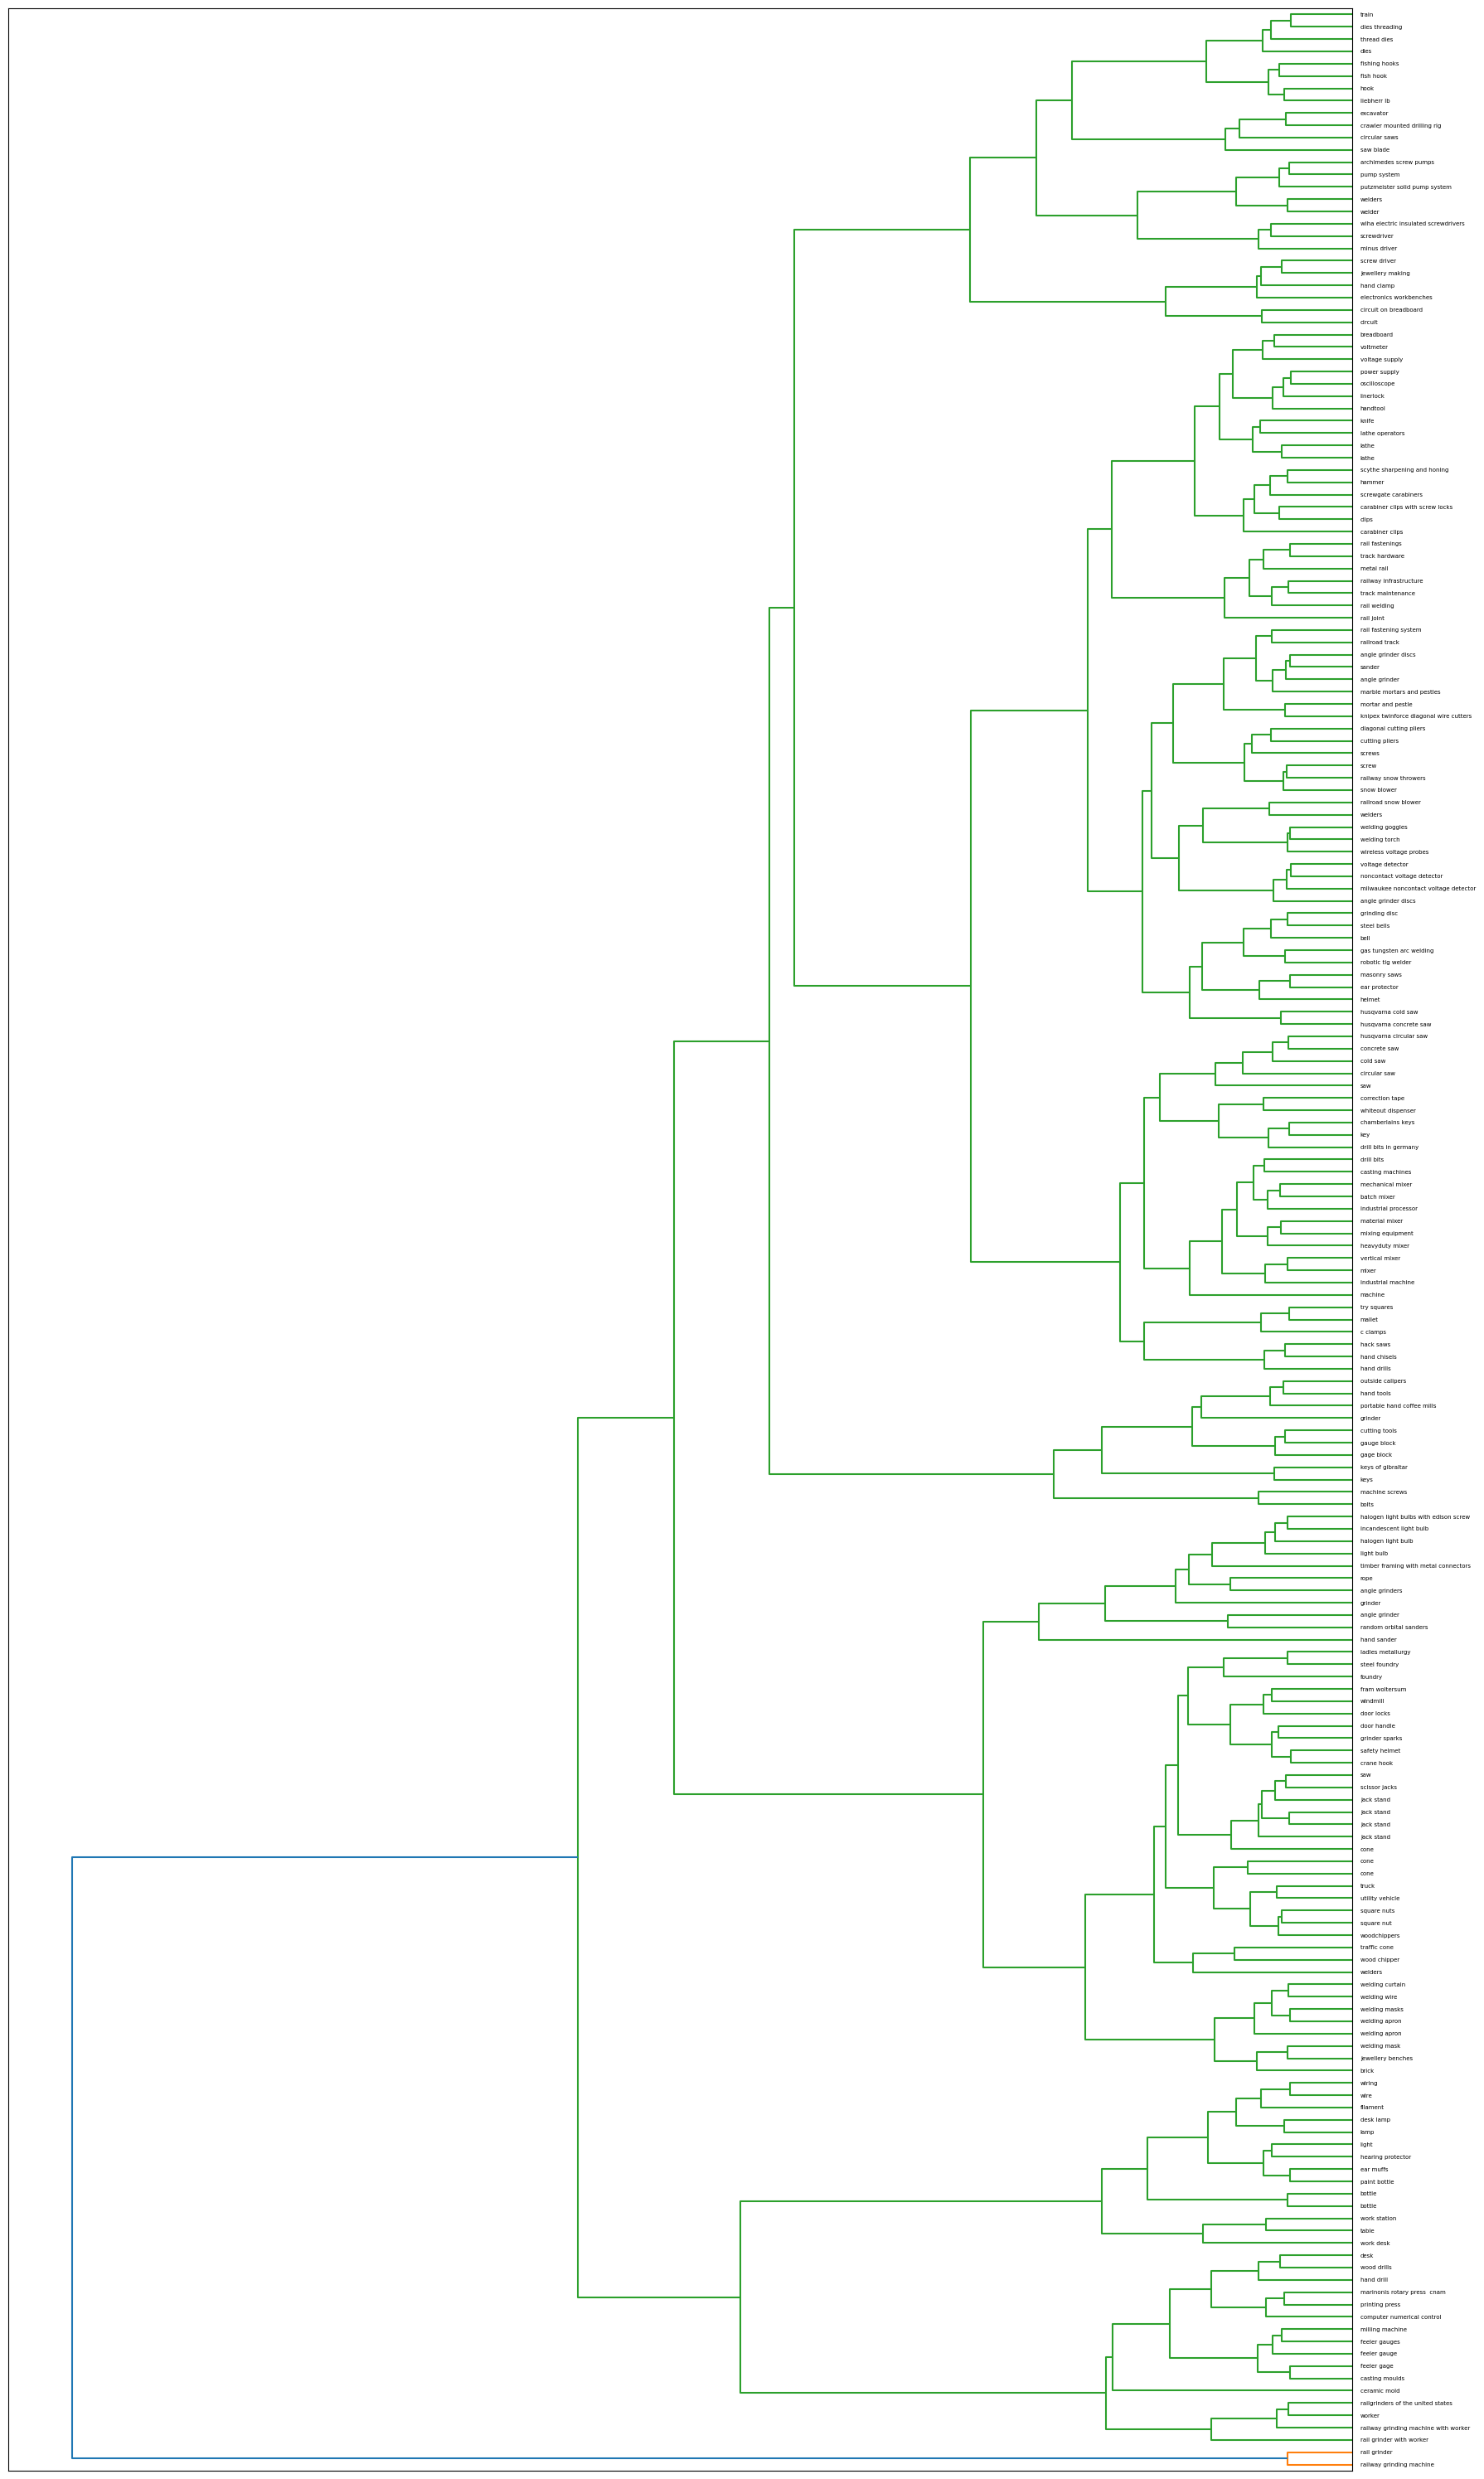

In [20]:
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix



def plot_hierarchical_clusters(linkage_matrix, data = df, p=100, figure_size=(8,12)):
    #set size
    fig, ax = plt.subplots(figsize=figure_size)
    label_titles = df['label'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=label_titles,
                    truncate_mode='lastp', p=p, no_plot=True)
    temp = {R["leaves"][ii]: label_titles[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(linkage_matrix, orientation="left", labels=label_titles,
                    truncate_mode='lastp', p=p, leaf_label_func=llf)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout()  
    plt.show()



linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)
np.set_printoptions(suppress=True)
print(linkage_matrix)

plot_hierarchical_clusters(linkage_matrix,
                           p=200,
                           data=df,
                           figure_size=(18, 30))